# Imports and definitions

In [28]:
import numpy as np
import qutip as qtp
import math
import cmath
import matplotlib.pyplot as plt
from qutip import *
from tqdm.notebook import tqdm
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy.integrate import quad
%matplotlib inline
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
blues = mpl.colormaps['Blues']
reds = mpl.colormaps['Reds']
import ROfunctions as ro
from ROfunctions import *
import scqubits as scq
from scipy import constants

## Define parameters and system Hamiltonian to extract $\chi$

In [29]:
N = 25 #qubit Hilbert space
M = 10 #resonator Hilbert space

#creation/annihilation operators in qubit subspace
c = destroy(N)
cdag = create(N)

#creation/annihilation operators in resonator subspace
a = destroy(M)
adag = create(M)

rnum = adag * a
resonator_num = tensor(qeye(N), rnum)

#fluxonium energy parameters (GHz)
Ej = 4.75
Ec = 1.25
El = 1.5

#resonator frequency (GHz)
w = 7.0
H_lc = w * (adag * a + 1/2)

#qubit-resonator coupling strength (GHz)
g = 0.05
coupling1 = tensor(c, adag)
coupling2 = tensor(cdag, a)
H_i = g * (coupling1 + coupling2)

#reduced charge and phase operators for fluxonium Hamiltonian
phi_naught = ((8 * Ec) / El)**(1/4)
n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
phi_op_HC = phi_op.dag()
phi_ext = np.linspace(np.pi, 1.3*np.pi, 101)

Cterm = 4 * Ec * (n_op)**2
Lterm = (1/2) * El * phi_op**2

qubitEdiff_r0 = []
qubitEdiff_r1 = []
resEdiff_q0 = []
resEdiff_q1 = []
chi = []

#loop over flux bias defined by phi_ext
for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_r0.append(frequencies[0].real)
    qubitEdiff_r1.append(frequencies[1].real)
    resEdiff_q0.append(frequencies[2].real)
    resEdiff_q1.append(frequencies[3].real)
    chi.append(chi_value.real * 1000)    

## Define global variables

In [30]:
n_readout = 10 #average cavity photon number
kappa = 2 * np.pi * 5 #resonator linewidith, 2*pi*MHz

In [31]:
chi_hfqp = 2 * np.pi * chi[0] #2*pi*MHz
chi_readout = 2 * np.pi * chi[-7] #2*pi*MHz, chosen to be at Phi_ext/Phi_0 = 0.641 based on other simulation results

# Calculation of SNR for static and flux-pulse-assisted readout

## Calculate SNR for readout at sweet-spot for comparison

In [32]:
tau = np.linspace(0.01, 1, 100) #microseconds
scaledSNR_hfqp, rawSNR_hfqp = SNR(n_readout, kappa, chi_hfqp, tau)

## Interpolation for $\chi$ vs $\Phi_{ext}/\Phi_{0}$

In [33]:
ramp_duration = 0.05 #time duration of flux pulse ramp in us

In [34]:
read_phi_ext = phi_ext[:-6] #array of flux bias points between sweet spot and readout
read_chi = chi[:-6] #array of dispersive shift between sweet spot and readout
chi_func_phi = interpolate.interp1d(read_phi_ext, read_chi) #chi as a function of external flux

t = []
for phi in read_phi_ext:
    time = (ramp_duration / (0.282 * np.pi)) * (phi - np.pi)
    t.append(time)
    
chi_func_t = interpolate.interp1d(t, read_chi, fill_value="extrapolate") #chi as a function of time

## Solve Langevin equation analytically during 50 ns flux pulse ramping to get $\alpha$

In [35]:
ep = math.sqrt(n_readout*(chi_readout**2 + (kappa)**2 / 4)) #epsilon --> drive amplitude

#solve differential equation to get alpha for two eigenstates (|0>, |1>)
def alphadot_0(alpha, time):
    dalpha0dt = -1j * 2 * np.pi * chi_func_t(time) * alpha - (1/2) * kappa * alpha + ep*(time/ramp_duration)**2
    return dalpha0dt

def alphadot_1(alpha, time):
    dalpha1dt = 1j * 2 * np.pi * chi_func_t(time) * alpha - (1/2) * kappa * alpha + ep*(time/ramp_duration)**2
    return dalpha1dt

alpha_init = [0+0j]
t_ramp = np.linspace(0, ramp_duration, 101) #times during flux pulse ramp

sol_alpha0 = solve_ivp(lambda time, alpha: alphadot_0(alpha, time), [t_ramp[0], t_ramp[-1]], alpha_init, t_eval=t_ramp)
sol_alpha1 = solve_ivp(lambda time, alpha: alphadot_1(alpha, time), [t_ramp[0], t_ramp[-1]], alpha_init, t_eval=t_ramp)

alpha0solution = sol_alpha0.y[0]
alpha1solution = sol_alpha1.y[0]

## Transformation of $\alpha$ to $\alpha_{out}$ using interpolation during flux pulse ramp

In [36]:
alpha_out_0 = []
alpha_out_1 = []

#calculation of alpha_out from alpha and alpha_in
for i, a in enumerate(alpha0solution):
    ep_td = ep*(t_ramp[i]/ramp_duration)**2
    aout0 = (-ep_td / math.sqrt(kappa)) + math.sqrt(kappa) * a
    alpha_out_0.append(aout0)

for j, b in enumerate(alpha1solution):
    ep_td = ep*(t_ramp[j]/ramp_duration)**2
    aout1 = (-ep_td / math.sqrt(kappa)) + math.sqrt(kappa) * b
    alpha_out_1.append(aout1)
    
aout0_func = interpolate.interp1d(t_ramp, alpha_out_0, fill_value="extrapolate")
aout1_func = interpolate.interp1d(t_ramp, alpha_out_1, fill_value="extrapolate")

#_ramp indicates during flux pulse ramping
scaledSNR_ramp = [] #scaled by average photon number population
rawSNR_ramp = []

#integration to get measurement operator which allows for calculation of SNR
for t in t_ramp:
    M_ramp = []
    tpts = np.linspace(0,t,1001)
    for i in tpts:
        alpha_zero = aout0_func(i)
        alpha_one = aout1_func(i)
        M_ramp.append(alpha_zero-alpha_one)
    SNRnumerator = np.sqrt(kappa)*abs(np.trapz(M_ramp))*np.diff(tpts)[0]
    SNRdenominator = math.sqrt(kappa * t)
    SNR_ramp = SNRnumerator / SNRdenominator
    rawSNR_ramp.append(SNR_ramp)
    scaledSNR_ramp.append(SNR_ramp / math.sqrt(n_readout))

 <ipython-input-36-760fe2e3ede2>: 32

## Solve Langevin equation for $\alpha$ and calculate SNR after flux pulse has reached its maximum amplitude at $\Phi_{ext}/\Phi_{0}$ = 0.641

In [37]:
def alphadot_0_fp(alpha, time): #while flux pulse is on, keeping qubit at readout point
    dalpha0dt_fp = -1j * chi_readout * alpha - (1/2) * kappa * alpha + ep
    return dalpha0dt_fp

def alphadot_1_fp(alpha, time): #after flux pulse
    dalpha1dt_fp = 1j * chi_readout * alpha - (1/2) * kappa * alpha + ep
    return dalpha1dt_fp

#initial point defined as last point during flux pulse ramp
alpha_init_0 = [alpha0solution[-1]]
alpha_init_1 = [alpha1solution[-1]]

t_fp = np.linspace(ramp_duration, 1, 1901) #once flux pulse has reached max amplitude, up to 1 us

#solve differential equation to get alpha
sol_alpha0_fp = solve_ivp(lambda time, alpha: alphadot_0_fp(alpha, time), [t_fp[0], t_fp[-1]], alpha_init_0, t_eval=t_fp)
sol_alpha1_fp = solve_ivp(lambda time, alpha: alphadot_1_fp(alpha, time), [t_fp[0], t_fp[-1]], alpha_init_1, t_eval=t_fp)

alpha0solution_fp = sol_alpha0_fp.y[0]
alpha1solution_fp = sol_alpha1_fp.y[0]

aout0 = []
aout1 = []

#calculation of alpha_out from alpha and alpha_in
for a in alpha0solution_fp:
    alphaout0 = (-ep / math.sqrt(kappa)) + math.sqrt(kappa) * a
    aout0.append(alphaout0)

for b in alpha1solution_fp:
    alphaout1 = (-ep / math.sqrt(kappa)) + math.sqrt(kappa) * b
    aout1.append(alphaout1)
    
aout0_func_fp = interpolate.interp1d(t_fp, aout0, fill_value="extrapolate")
aout1_func_fp = interpolate.interp1d(t_fp, aout1, fill_value="extrapolate")

scaledSNR_fp = []
rawSNR_fp = []

#integration to get measurement operator which allows for calculation of SNR during flux pulse at max amplitude
for t in t_fp:
    M = []
    tps = np.linspace(0,t,1001)
    for tp in tps:
        alpha_zero = aout0_func_fp(tp) if tp>0.05 else aout0_func(tp)
        alpha_one = aout1_func_fp(tp) if tp>0.05 else aout1_func(tp)
        M.append(alpha_zero-alpha_one)
    SNRnum = np.sqrt(kappa) * abs(np.trapz(M)*np.diff(tps)[0])
    SNRdenom = math.sqrt(kappa * t)
    SNR = SNRnum / SNRdenom
    rawSNR_fp.append(SNR)
    scaledSNR_fp.append(SNR / math.sqrt(n_readout))

#concatenate time and SNR arrays to capture during and after flux pulse
totalTime = np.concatenate((t_ramp, t_fp))
totalRawSNR = np.concatenate((rawSNR_ramp, rawSNR_fp))
totalScaledSNR = np.concatenate((scaledSNR_ramp, scaledSNR_fp))

# Conversion to readout error and visualization

In [38]:
fidelity_hfqp = []
error_hfqp = []
fidelity_pulse = []
error_pulse = []

#readout at sweet-spot
for i in rawSNR_hfqp:
    fid = (1 - (math.erfc(i/2)/2))
    fidelity_hfqp.append(fid)
    error = (math.erfc(i/2)/2)
    error_hfqp.append(error)
#readout with flux pulse
for i in totalRawSNR:
    fid = (1 - (math.erfc(i/2)/2))
    fidelity_pulse.append(fid)
    error = (math.erfc(i/2)/2)
    error_pulse.append(error)

## Adding <100% measurement efficiency

In [ ]:
eta = 0.25
snr_loweff = np.sqrt(eta)*totalRawSNR

error_loweff = []

for i in snr_loweff:
    error = (math.erfc(i/2)/2)
    error_loweff.append(error)

## Plotting

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, dpi=250, sharex=True)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.25)
fig.set_size_inches(3.40457, 3.0)
font = {'size' : 8}
mpl.rc('font', **font)

ax1.plot(tau * 1000, rawSNR_hfqp, label = "$\Phi_{ext}/\Phi_{0}$=0.5, $\eta = 1$", color="tab:red", linewidth=1.5)
ax1.plot(totalTime * 1000, snr_loweff, label = "$\chi$($\phi_{ext}$(t)), $\eta = 0.25$", color=blues(0.35), linewidth=1.5)
ax1.plot(totalTime * 1000, totalRawSNR, label = "$\chi$($\phi_{ext}$(t)), $\eta = 1$", color=blues(0.75), linewidth=1.5)
ax1.set_ylabel(r"SNR")
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 15)
ax1.set_yticks([0.0, 5.0, 10.0, 15.0])
ax1.tick_params(axis='y', pad=4)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.legend(loc='lower left', bbox_to_anchor=(-0.02, 0.42), handletextpad=0.2, frameon=False)
ax1.annotate("(a)", xy=(0.01, 1.05), xycoords="axes fraction")

ax2.plot(tau * 1000, error_hfqp, label = "$\Phi_{ext}/\Phi_{0}$=0.5, $\eta = 1$", color="tab:red", linewidth=1.5)
ax2.plot(totalTime * 1000, error_loweff, label = "$\chi$($\phi_{ext}$,(t)), $\eta = 0.25$", color=blues(0.35), linewidth=1.5)
ax2.plot(totalTime * 1000, error_pulse, label = "$\chi$($\phi$,(t)), $\eta = 1$", color=blues(0.75), linewidth=1.5)
ax2.set_ylabel(r"Readout Error")
ax2.set_xlabel(r"Integration Time, $\tau$ (ns)")
ax2.set_xlim(0, 200) #nanoseconds
ax2.set_yscale("log")
ax2.set_ylim(1e-9, 1)
ax2.tick_params(axis='y', pad=1.5)
ax2.set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200])
ax2.set_xticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200])
ax2.annotate("(b)", xy=(0.01, 1.05), xycoords="axes fraction")

plt.show()

# Calculate error from Purcell decay

## Get bare detuning, $\Delta_{10}$, as a function of time

In [ ]:
# set qubit-resonator coupling strength to 0
g = 0
H_i = g * (coupling1 + coupling2)

N = 25 #qubit Hilbert space
M = 10 #resonator Hilbert space

phi_ext = np.linspace(0.5*2*np.pi, 0.641*2*np.pi, 142)

qubitEdiff_10 = [] # GHz
delta10 = [] # MHz

for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_10.append(frequencies[0].real)
    detuning10 = frequencies[0].real - w
    delta10.append(detuning10*1000)

In [ ]:
t = []

flux_shift = phi_ext[-1] - phi_ext[0]

for phi in phi_ext:
    ss = 0.5*2*np.pi
    time = (ramp_duration/(flux_shift))*(phi-ss)
    t.append(time)
    
delta10_func_t = interpolate.interp1d(t, np.array(delta10), fill_value="extrapolate")

## Get effective couplings ($g_{10}$)

In [ ]:
phi_ext_norm = np.array(phi_ext)/(2*np.pi)

g_total = 0.05 #GHz
matrix_elem10 = []
g_eff10 = [] #MHz

for phi in phi_ext_norm:
    qubit = scq.Fluxonium(EJ = Ej, EC = Ec, EL = El, flux = phi, cutoff = 50)
    n10 = np.abs(qubit.matrixelement_table('n_operator')[1, 0])
    matrix_elem10.append(n10)
    g_eff10.append(g_total*1000*n10)

g_eff10_func_t = interpolate.interp1d(t, np.array(g_eff10), fill_value="extrapolate")

## Calculate Purcell rate and error induced for static readout at sweet-spot

In [ ]:
# all in units of MHz
kappa_MHz = kappa/(2*np.pi)
detuning_ss = delta10[0]
g_eff10_ss = g_eff10[0]

# rate of Purcell decay at sweet-spot in MHz
purcell_rate_ss = (g_eff10_ss**2 * kappa_MHz) / (detuning_ss)**2

# error contribution from Purcell decay
purcell_error_ss = []

for t in tau:
    error = (1/4)*(1-np.exp(-purcell_rate_ss*t))
    purcell_error_ss.append(error)

# sum SNR limited error and Purcell induced error
sep_purcell_error_ss = []

for i, value in enumerate(error_hfqp):
    sep_purcell_error_ss.append(error_hfqp[i]+purcell_error_ss[i])

## Calculate Purcell rate and error induced for flux-pulse-assisted readout

In [ ]:
purcell_rate_fpa = [] # MHz
purcell_error_fpa = []

for i, time in enumerate(totalTime):
    if time <= ramp_duration:
        g10 = g_eff10_func_t(time)
        delta10 = delta10_func_t(time)
        purcell_rate = (g10**2 * kappa_MHz)/(delta10**2)
        purcell_rate_fpa.append(purcell_rate)
        error = (1/4)*(1-np.exp(-purcell_rate*time))
        purcell_error_fpa.append(error)
        
    elif time > ramp_duration:
        g10 = g_eff10_func_t(ramp_duration)
        delta10 = delta10_func_t(ramp_duration)
        purcell_rate = (g10**2 * kappa_MHz)/(delta10**2)
        purcell_rate_fpa.append(purcell_rate)
        error = (1/4)*(1-np.exp(-purcell_rate*time))
        purcell_error_fpa.append(error)
        
total_error_fpa_maxeff = []
total_error_fpa_loweff = []

for i, value in enumerate(error_pulse):
    total_error_fpa_maxeff.append(error_pulse[i]+purcell_error_fpa[i])
    total_error_fpa_loweff.append(error_loweff[i]+purcell_error_fpa[i])

## Plotting with Purcell error included

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, dpi=250, sharex=True)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.25)
fig.set_size_inches(3.40457, 3.0)
font = {'size' : 8}
mpl.rc('font', **font)

ax1.plot(tau * 1000, rawSNR_hfqp, label = "$\Phi_{ext}/\Phi_{0}$=0.5", color=reds(0.6), linewidth=1.5)
ax1.plot(totalTime * 1000, snr_loweff, label =  "$\chi$($\phi_{ext}$(t)), $\eta = 0.25$", color=blues(0.35), linewidth=1.5)
ax1.plot(totalTime * 1000, totalRawSNR, label = "$\chi$($\phi_{ext}$(t))", color=blues(0.75), linewidth=1.5)
ax1.set_ylabel(r"SNR")
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 15)
ax1.set_yticks([0.0, 5.0, 10.0, 15.0])
ax1.tick_params(axis='y', pad=4)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.legend(loc='lower left', bbox_to_anchor=(-0.02, 0.42), handletextpad=0.2, frameon=False, fontsize = 7)
ax1.annotate("(a)", xy=(0.01, 1.05), xycoords="axes fraction")
handles, labels = ax1.get_legend_handles_labels()
order = [2, 1, 0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', bbox_to_anchor=(-0.02, 0.48), handletextpad=0.4, handlelength = 1.28, frameon=False, fontsize = 7)

ax2.plot(tau * 1000, sep_purcell_error_ss, label = r"$E_{total}$", color=reds(0.6), linewidth=1.5)
ax2.plot(totalTime * 1000, purcell_error_fpa, label = r"$E_{Purcell}$", color=blues(0.3), linestyle='dotted')
ax2.plot(totalTime * 1000, error_loweff, label = r"$E_{sep}$, $\eta = 0.25$", color=blues(0.35), linewidth=1.5)
ax2.plot(totalTime * 1000, np.array(total_error_fpa_loweff), label = r"$E_{total}$, $\eta = 0.25$", color=blues(0.5), linestyle='dashdot', dashes=(3, 1, 1, 1))
ax2.plot(totalTime * 1000, error_pulse, label = r"$E_{sep}$", color=blues(0.75), linewidth=1.5)
ax2.plot(totalTime * 1000, np.array(total_error_fpa_maxeff), label = r"$E_{total}$", color=blues(0.9), linestyle='dashdot', dashes=(3, 1, 1, 1))
ax2.set_ylabel(r"Readout Error")
ax2.set_xlabel(r"Integration Time, $\tau$ (ns)")
ax2.set_xlim(0, 200) #nanoseconds
ax2.set_yscale("log")
ax2.set_ylim(1e-8, 1)
ax2.tick_params(axis='y', pad=1.5)
ax2.set_yticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0])
ax2.annotate("(b)", xy=(0.01, 1.05), xycoords="axes fraction")
handles, labels = ax2.get_legend_handles_labels()
order2a = [0, 1, 4, 5]
xa = -0.02
ya = 0.59
legend2a = ax2.legend([handles[idx] for idx in order2a],[labels[idx] for idx in order2a], loc='lower left', bbox_to_anchor=(xa, ya), handletextpad=0.4, frameon=False, handlelength = 1.28, fontsize = 7, labelspacing=0.1, ncols=2, columnspacing=0.4)
order2b = [2, 3]
xb = -0.02
yb = 0.35
legend2b = ax2.legend([handles[idx] for idx in order2b],[labels[idx] for idx in order2b], loc='lower left', bbox_to_anchor=(xb, yb), handletextpad=0.4, frameon=False, handlelength = 1.28, fontsize = 7, labelspacing=0.1)
fig.gca().add_artist(legend2a)

# Non-QNDness during flux ramping (Appendix B)

## Get bare detuning, $\Delta_{31}$, as a function of time

In [44]:
# set qubit-resonator coupling strength to 0
g = 0
H_i = g * (coupling1 + coupling2)

N = 25 #qubit Hilbert space
M = 10 #resonator Hilbert space

phi_ext = np.linspace(0.5*2*np.pi, 0.641*2*np.pi, 142)

qubitEdiff_31 = [] # GHz
delta31 = [] # MHz

for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value = truncate_detuning(H_sys, resonator_num)
    qubitEdiff_31.append(frequencies[4].real)
    detuning31 = frequencies[4].real - w
    delta31.append(detuning31*1000)

In [45]:
t = []

for phi in phi_ext:
    ss = 0.5*2*np.pi
    flux_shift = 0.141*2*np.pi
    time = (ramp_duration/(flux_shift))*(phi-ss)
    t.append(time)

In [46]:
delta31_angfreq = 2*np.pi*np.array(delta31)
delta31_func_t = interpolate.interp1d(t, delta31_angfreq, fill_value="extrapolate")

## Get effective coupling ($g_{31}$) vs time

In [47]:
phi_ext_norm = np.array(phi_ext)/(2*np.pi)

g_total = 0.05 #GHz
matrix_elem31 = []
g_eff31 = [] #MHz

for phi in phi_ext_norm:
    qubit = scq.Fluxonium(EJ = Ej, EC = Ec, EL = El, flux = phi, cutoff = 50)
    n31 = np.abs(qubit.matrixelement_table('n_operator')[3, 1])
    matrix_elem31.append(n31)
    g_eff31.append(g_total*n31*1000)

In [48]:
g_eff31_angfreq = 2*np.pi*np.array(g_eff31)
g31_func_t = interpolate.interp1d(t, g_eff31_angfreq, fill_value="extrapolate")

## Get sqrt of intracavity photon population

In [52]:
# NOTE: THIS CELL RELIES ON HAVING RUN THROUGH SECTION 2.2

ep = math.sqrt(n_readout*(chi_readout**2 + (kappa)**2 / 4)) #epsilon --> drive amplitude

#solve differential equation to get alpha for two eigenstates (|0>, |1>)
def alphadot_0(alpha, time):
    dalpha0dt = -1j * 2 * np.pi * chi_func_t(time) * alpha - (1/2) * kappa * alpha + ep*(time/ramp_duration)**2
    return dalpha0dt

def alphadot_1(alpha, time):
    dalpha1dt = 1j * 2 * np.pi * chi_func_t(time) * alpha - (1/2) * kappa * alpha + ep*(time/ramp_duration)**2
    return dalpha1dt

alpha_init = [0+0j]
t_ramp = np.linspace(0, ramp_duration, 101) #times during flux pulse ramp

sol_alpha0 = solve_ivp(lambda time, alpha: alphadot_0(alpha, time), [t_ramp[0], t_ramp[-1]], alpha_init, t_eval=t_ramp)
sol_alpha1 = solve_ivp(lambda time, alpha: alphadot_1(alpha, time), [t_ramp[0], t_ramp[-1]], alpha_init, t_eval=t_ramp)

alpha0solution = sol_alpha0.y[0]
alpha1solution = sol_alpha1.y[0]

In [53]:
abs_alpha1solution = np.abs(alpha1solution)
alpha1_func_t = interpolate.interp1d(t_ramp, abs_alpha1solution, fill_value="extrapolate")

## Time-evolution

In [57]:
# basis(2,1) represents q=3, r=0
init_state = basis(2, 0) # represents q=1, r=1

def delta31half(t, args):
    _delta31 = delta31_func_t(t) # MHz*2pi(us)
    return _delta31/2

def off_diag(t, args):
    geff = g31_func_t(t) # MHz*2pi(us)
    absalpha1 = alpha1_func_t(t)
    return geff*absalpha1

In [58]:
H0 = qzero(2)
H1 = sigmaz()
H2 = sigmax()

H31_swap = [H0, [H1, delta31half], [H2, off_diag]]
output = mesolve(H=H31_swap, rho0=init_state, tlist=np.array(t))

q1r1pop = []
q3r0pop = []

for i in range(len(output.states)):
    state = output.states[i]
    sqrt_q1r1pop = state.extract_states(0)[0][0]
    sqrt_q3r0pop = state.extract_states(1)[0][0]
    q1r1pop.append(np.abs(sqrt_q1r1pop)**2)
    q3r0pop.append(np.abs(sqrt_q3r0pop)**2)

## Plotting

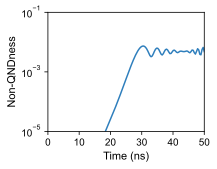

In [60]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.8, hspace=0.6)
# fig.set_size_inches(2.5,3.40457)
fig.set_size_inches(3.40457, 2.0)

font = {'size' : 8}
plt.rc('font', **font)

ax.plot(np.array(t)*1000, q3r0pop, color=blues(0.7))
ax.set_xlim(0, 50)
ax.set_ylim(0.00001, 1e-1)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Non-QNDness')
ax.set_yscale('log')

# Estimate T$_{1}$ (Appendix C)

## Initialize parameters and functions

In [6]:
N = 25 #qubit Hilbert space
M = 10 #resonator Hilbert space

#creation/annihilation operators in qubit subspace
c = destroy(N)
cdag = create(N)

#creation/annihilation operators in resonator subspace
a = destroy(M)
adag = create(M)

rnum = adag * a
resonator_num = tensor(qeye(N), rnum)

#qubit-resonator coupling strength (GHz)
g = 0.05
coupling1 = tensor(c, adag)
coupling2 = tensor(cdag, a)
H_i = g * (coupling1 + coupling2)

phi_ext = np.linspace(0.5*2*np.pi, 0.641*2*np.pi, 142)

qubitEdiff_10 = [] # GHz
#loop over flux bias defined by phi_ext
for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_10.append(frequencies[0].real)

In [8]:
phi_for_readout = np.linspace(0.5, 0.641, 142)
phi_matrix_elem10 = []

for phi in phi_for_readout:
    qubit = scq.Fluxonium(EJ = Ej, EC = Ec, EL = El, flux = phi, cutoff = 50)
    phi10 = np.abs(qubit.matrixelement_table('phi_operator')[1, 0])
    phi_matrix_elem10.append(phi10)

t = []
for phi in phi_ext:
    ss = 0.5*2*np.pi
    flux_shift = 0.141*2*np.pi
    time = (ramp_duration/(flux_shift))*(phi-ss)
    t.append(time)
    
phi10_func_t = interpolate.interp1d(t, phi_matrix_elem10, fill_value="extrapolate")
freq10_func_t = interpolate.interp1d(t, qubitEdiff_10, fill_value="extrapolate")

In [9]:
kb = constants.value('Boltzmann constant') # Joule/Kelvin
h = constants.value('Planck constant') # Joule Hz^-1
loss_tangent = 2e-6
temp = 20e-3 # Kelvin
freq_ss_Hz = qubitEdiff_10[0]*10**9
freq_ro_Hz = qubitEdiff_10[-1]*10**9
Ec_joule = Ec*10**9*h
trig_arg_ss = (h*freq_ss_Hz)/(2*kb*temp)

In [10]:
def coth(x):
    return math.cosh(x)/math.sinh(x)

def dielectric_loss_rate(frequency, phi_elem, trig_arg):
    rate = ((h*frequency**2)/(4*Ec_joule))*(phi_elem**2)*loss_tangent*coth(trig_arg)
    return rate

## T$_{1}$ at sweet-spot

In [12]:
dielectric_rate_ss_Hz = dielectric_loss_rate(freq_ss_Hz, phi_matrix_elem10[0], trig_arg_ss)
dielectric_rate_ss = dielectric_rate_ss_Hz*10**(-6) #MHz
T1_ss = 1/(dielectric_rate_ss)

## T$_{1}$ vs flux bias

In [14]:
dielectric_rate_fp = [] #MHz
T1_fp = [] #us

for i, time in enumerate(t):
    freq10_Hz = freq10_func_t(time)*10**9
    phi10 = phi10_func_t(time)
    trig_arg = (h*freq10_Hz)/(2*kb*temp)
    dielectric_rate = dielectric_loss_rate(freq10_Hz, phi10, trig_arg)*10**(-6)
    dielectric_rate_fp.append(dielectric_rate)
    T1_fp.append(1/dielectric_rate)

Text(0, 0.5, 'T$_{1}$ ($\\mu$s)')

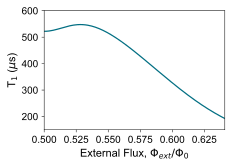

In [18]:
#1D plot of T1 vs external flux up to readout point
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.plot(phi_ext/(2*np.pi), np.array(T1_fp), linewidth=1.25)

ax.set_xlim(0.5, 0.641)
ax.set_ylim(150, 600)

ax.set_xlabel(r"External Flux, $\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"T$_{1}$ ($\mu$s)")